In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

os.makedirs('results', exist_ok=True)

Using device: cuda


# Cargar datos

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# Convertir etiquetas a par (0) / impar (1)
mnist_train.targets = mnist_train.targets % 2
mnist_test.targets = mnist_test.targets % 2

train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

# Definición de modelos

In [3]:
# Modelo CNN original (para cargar pesos preentrenados)


class CNN(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 16, kernel_size=4),
            nn.ReLU(True),
        )

        self.fc = nn.Sequential(
            nn.Linear(16*9*9, num_classes),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


# Modelo CNN para clasificación par/impar (con capas convolucionales congeladas)
class CNN_ParImpar(nn.Module):
    def __init__(self, pretrained_model: CNN):
        super().__init__()
        # Copiar y congelar capas convolucionales del modelo preentrenado
        self.conv = pretrained_model.conv
        for param in self.conv.parameters():
            param.requires_grad = False

        # Nueva capa fully connected para clasificación binaria
        self.fc = nn.Sequential(
            nn.Linear(16*9*9, 2),  # 2 clases: par (0) e impar (1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


# Cargar modelo preentrenado
print("\n" + "="*60)
print("📂 Cargando modelo preentrenado...")
print("="*60)

pretrained_cnn = CNN(num_classes=10)
pretrained_cnn.load_state_dict(torch.load('results/old_model.pth', map_location=device))
pretrained_cnn.to(device)
print("✅ Modelo preentrenado cargado desde: results/old_model.pth")

# Crear nuevo modelo con capas convolucionales congeladas
model = CNN_ParImpar(pretrained_cnn).to(device)
print("✅ Modelo CNN_ParImpar creado con capas convolucionales congeladas")

# Mostrar parámetros entrenables
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\n📊 Parámetros del modelo:")
print(f"  • Total: {total_params:,}")
print(f"  • Entrenables: {trainable_params:,}")
print(f"  • Congelados: {frozen_params:,}")
print("="*60 + "\n")


📂 Cargando modelo preentrenado...
✅ Modelo preentrenado cargado desde: results/old_model.pth
✅ Modelo CNN_ParImpar creado con capas convolucionales congeladas

📊 Parámetros del modelo:
  • Total: 11,634
  • Entrenables: 2,594
  • Congelados: 9,040



# Funciones de evaluación

In [4]:


def evaluate_on_test_set(model, test_loader, criterion, device):
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Calcular accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Guardar predicciones
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    return {
        'loss': avg_test_loss,
        'accuracy': test_accuracy,
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels)
    }


def evaluate_model(model, test_loader, criterion, device, epoch):
    print(f"\n{'='*60}")
    print(f"📊 Evaluating at Epoch {epoch+1}")
    print(f"{'='*60}")

    test_metrics = evaluate_on_test_set(model, test_loader, criterion, device)
    test_metrics['epoch'] = epoch

    print(f"\n📈 Test Set Evaluation:")
    print(f"  • Loss: {test_metrics['loss']:.4f}")
    print(f"  • Accuracy: {test_metrics['accuracy']:.2f}%")
    print(f"{'='*60}\n")

    return test_metrics

# Funciones de training

In [5]:


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()

    epoch_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Estadísticas
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

# Training loop

In [6]:
print("\n" + "="*60)
print("🚀 STARTING TRAINING")
print("="*60)

# Hiperparámetros
lr = 0.001
num_epochs = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

print(f"📋 Configuración de entrenamiento:")
print(f"  • Learning rate: {lr}")
print(f"  • Epochs: {num_epochs}")
print(f"  • Optimizer: Adam")
print(f"  • Loss: CrossEntropyLoss")
print(f"  • Capas convolucionales: CONGELADAS (transfer learning)")
print("="*60 + "\n")

# Almacenar métricas
train_losses = []
train_accs = []
train_times = []
test_results = []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    end_time = time.time()
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_times.append(end_time - start_time)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%,"
          f" Time: {end_time - start_time:.2f}s")

    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1 or epoch == 0:
        test_metrics = evaluate_model(model, test_loader, criterion, device, epoch)
        test_results.append(test_metrics)

print("\n" + "="*60)
print("✅ TRAINING COMPLETED")
print("="*60)

torch.save(model.state_dict(), 'results/model_odd_even.pth')
print("💾 Model saved to: results/model_odd_even.pth")


🚀 STARTING TRAINING
📋 Configuración de entrenamiento:
  • Learning rate: 0.001
  • Epochs: 15
  • Optimizer: Adam
  • Loss: CrossEntropyLoss
  • Capas convolucionales: CONGELADAS (transfer learning)

Epoch 1/15 - Train Loss: 0.0569, Train Acc: 97.90%, Time: 12.95s

📊 Evaluating at Epoch 1

📈 Test Set Evaluation:
  • Loss: 0.0353
  • Accuracy: 98.87%

Epoch 2/15 - Train Loss: 0.0326, Train Acc: 98.86%, Time: 12.01s
Epoch 3/15 - Train Loss: 0.0291, Train Acc: 99.00%, Time: 11.95s
Epoch 4/15 - Train Loss: 0.0272, Train Acc: 99.07%, Time: 12.05s
Epoch 5/15 - Train Loss: 0.0258, Train Acc: 99.10%, Time: 11.87s

📊 Evaluating at Epoch 5

📈 Test Set Evaluation:
  • Loss: 0.0369
  • Accuracy: 98.82%

Epoch 6/15 - Train Loss: 0.0245, Train Acc: 99.17%, Time: 11.89s
Epoch 7/15 - Train Loss: 0.0238, Train Acc: 99.15%, Time: 11.75s
Epoch 8/15 - Train Loss: 0.0227, Train Acc: 99.21%, Time: 11.80s
Epoch 9/15 - Train Loss: 0.0221, Train Acc: 99.24%, Time: 11.69s
Epoch 10/15 - Train Loss: 0.0220, Trai

# Guardar métricas

In [7]:

training_metrics = {
    'epoch': list(range(1, num_epochs + 1)),
    'loss': train_losses,
    'accuracy': train_accs
}
df_training = pd.DataFrame(training_metrics)
df_training.to_csv('results/training_metrics.csv', index=False)
print("💾 Training metrics saved to: results/training_metrics.csv")

test_metrics_dict = {
    'epoch': [r['epoch'] + 1 for r in test_results],
    'loss': [r['loss'] for r in test_results],
    'accuracy': [r['accuracy'] for r in test_results]
}
df_test = pd.DataFrame(test_metrics_dict)
df_test.to_csv('results/test_metrics.csv', index=False)
print("💾 Test metrics saved to: results/test_metrics.csv")

💾 Training metrics saved to: results/training_metrics.csv
💾 Test metrics saved to: results/test_metrics.csv


# Visualizaciones

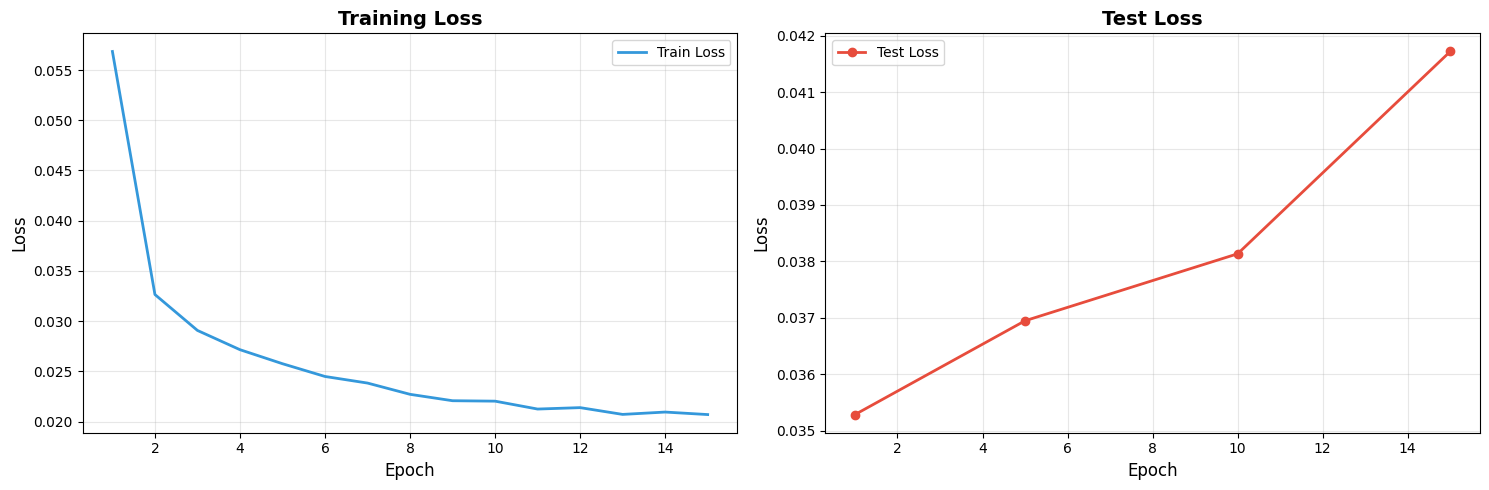

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss
axes[0].plot(range(1, num_epochs + 1), train_losses,
             label='Train Loss', linewidth=2, color='#3498db')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test Loss
test_epochs = [r['epoch'] + 1 for r in test_results]
test_losses = [r['loss'] for r in test_results]
axes[1].plot(test_epochs, test_losses,
             label='Test Loss', linewidth=2, marker='o', color='#e74c3c')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Test Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/losses_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

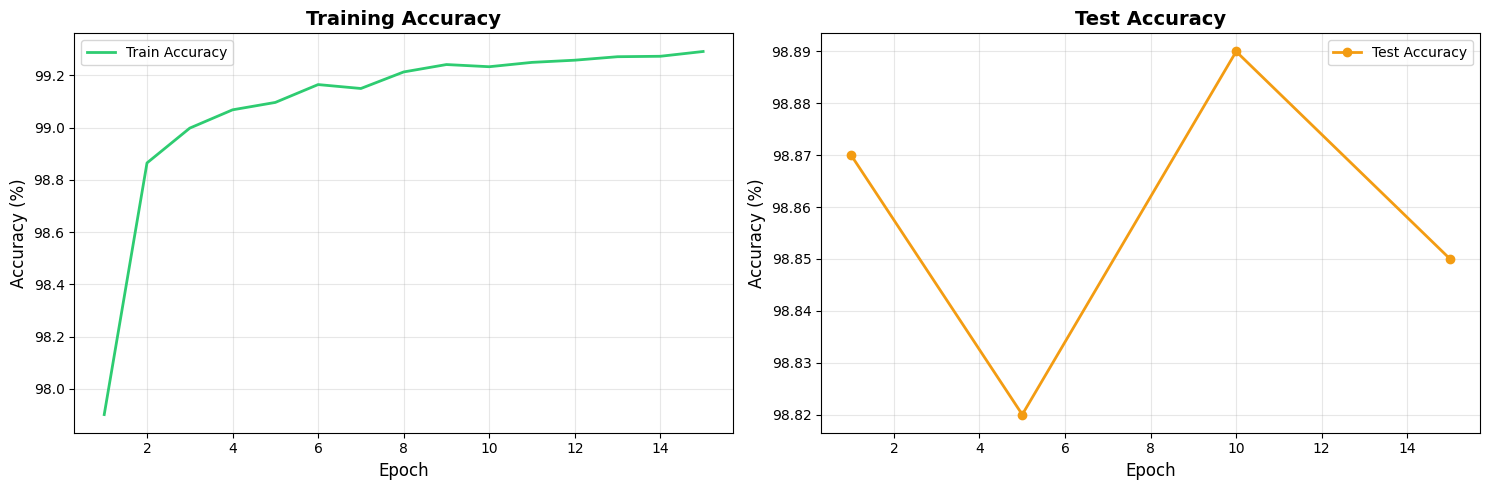

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training Accuracy
axes[0].plot(range(1, num_epochs + 1), train_accs,
             label='Train Accuracy', linewidth=2, color='#2ecc71')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test Accuracy
test_accs = [r['accuracy'] for r in test_results]
axes[1].plot(test_epochs, test_accs,
             label='Test Accuracy', linewidth=2, marker='o', color='#f39c12')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Test Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

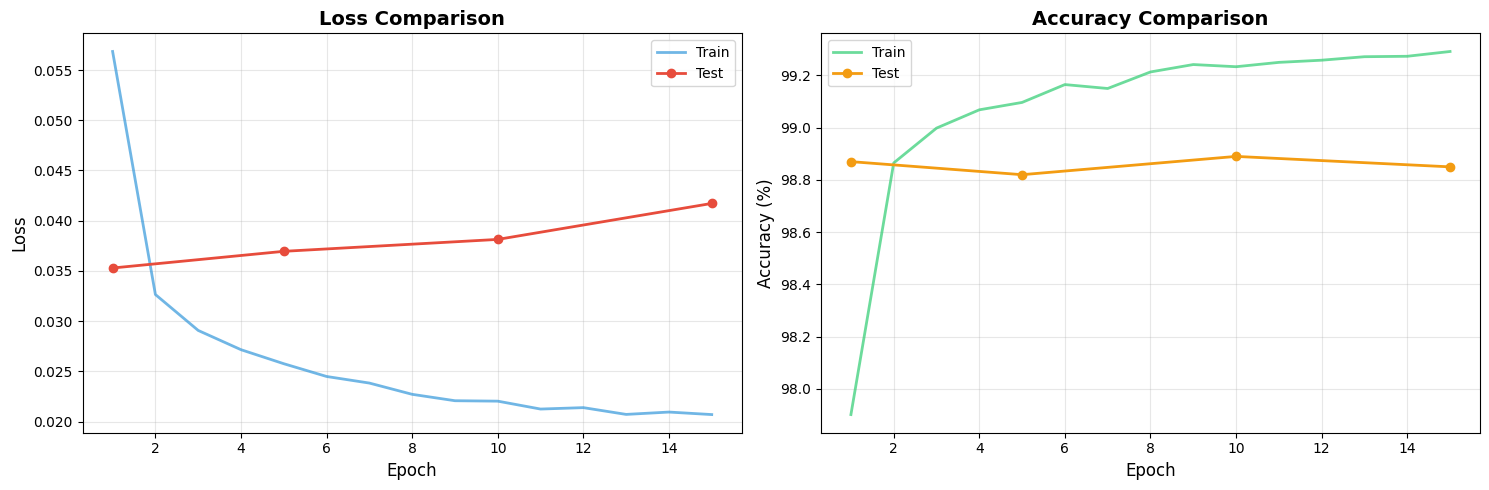

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(range(1, num_epochs + 1), train_losses,
             label='Train', linewidth=2, alpha=0.7, color='#3498db')
axes[0].plot(test_epochs, test_losses,
             label='Test', linewidth=2, marker='o', color='#e74c3c')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(range(1, num_epochs + 1), train_accs,
             label='Train', linewidth=2, alpha=0.7, color='#2ecc71')
axes[1].plot(test_epochs, test_accs,
             label='Test', linewidth=2, marker='o', color='#f39c12')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/train_vs_test.png', dpi=150, bbox_inches='tight')
plt.show()

# Evaluación final y matriz de confusión


📊 FINAL EVALUATION

Final Test Accuracy: 98.85%
Final Test Loss: 0.0417


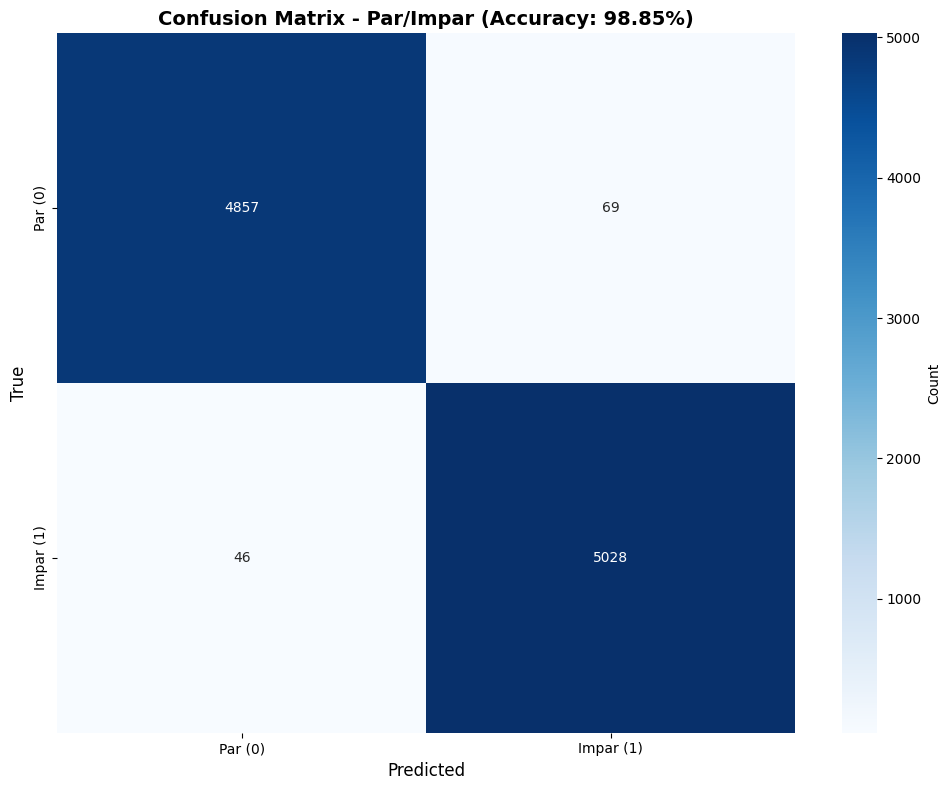

In [11]:
print("\n" + "="*60)
print("📊 FINAL EVALUATION")
print("="*60)

final_results = evaluate_on_test_set(model, test_loader, criterion, device)

print(f"\nFinal Test Accuracy: {final_results['accuracy']:.2f}%")
print(f"Final Test Loss: {final_results['loss']:.4f}")

# Matriz de confusión
cm = confusion_matrix(final_results['labels'], final_results['predictions'])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'},
            xticklabels=['Par (0)', 'Impar (1)'],
            yticklabels=['Par (0)', 'Impar (1)'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(f'Confusion Matrix - Par/Impar (Accuracy: {final_results["accuracy"]:.2f}%)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()


❌ Total errors: 115/10000 (1.15%)


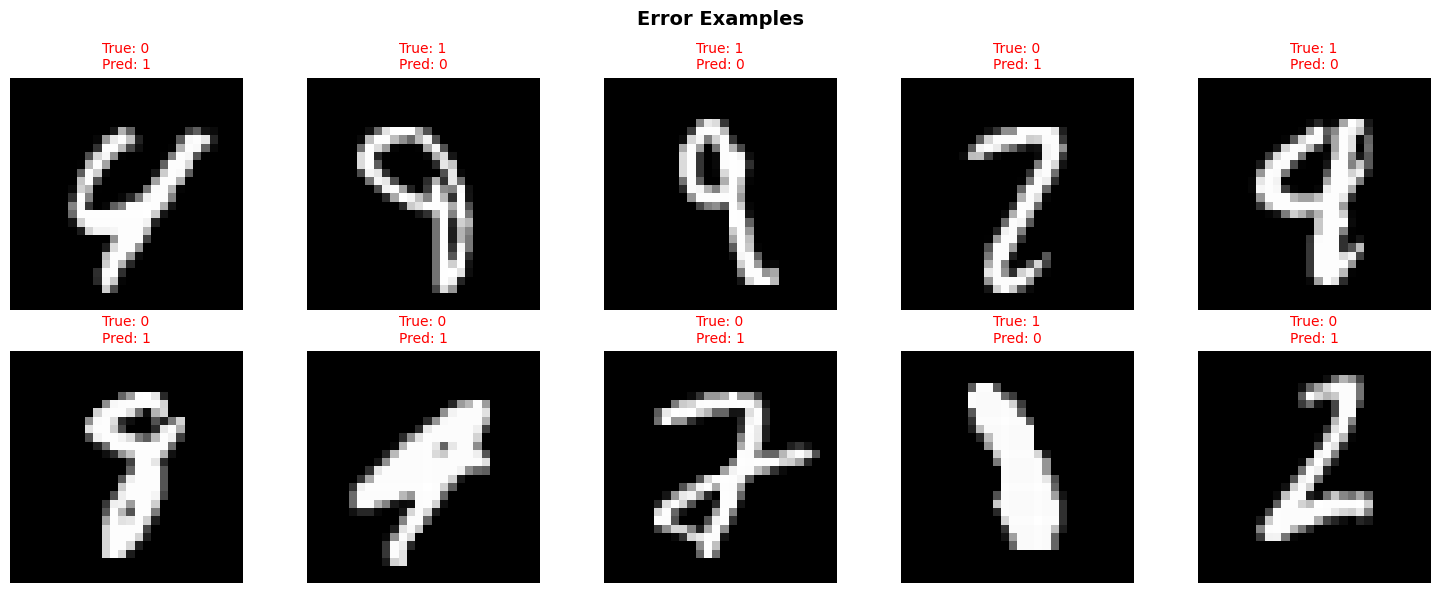


✅ ALL RESULTS SAVED IN 'results/' FOLDER


In [12]:
# Análisis de errores
errors_idx = np.where(final_results['predictions'] != final_results['labels'])[0]
print(f"\n❌ Total errors: {len(errors_idx)}/{len(final_results['labels'])} "
      f"({len(errors_idx)/len(final_results['labels'])*100:.2f}%)")

if len(errors_idx) > 0:
    # Visualizar algunos errores
    n_errors = min(10, len(errors_idx))
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    # Obtener imágenes del test set
    test_images = []
    for imgs, _ in test_loader:
        test_images.append(imgs)
    test_images = torch.cat(test_images, dim=0)

    for i in range(n_errors):
        idx = errors_idx[i]
        img = test_images[idx].squeeze().cpu().numpy()

        # Desnormalizar
        img = (img + 1) / 2

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(
            f'True: {final_results["labels"][idx]}\n'
            f'Pred: {final_results["predictions"][idx]}',
            fontsize=10, color='red'
        )
        axes[i].axis('off')

    plt.suptitle('Error Examples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('results/error_examples.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\n" + "="*60)
print("✅ ALL RESULTS SAVED IN 'results/' FOLDER")
print("="*60)